In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
import west_ic_antenna as ic
from scipy.optimize import minimize

In [14]:
# 集中管理 front_face 文件路径和命名
front_faces = {
    "front_face_vacuum": '../west_ic_antenna/data/Sparameters/front_faces/WEST_ICRH_antenna_front_face_curved_30to70MHz.s4p',
    "front_face_aquarium": '../west_ic_antenna/data/Sparameters/front_faces/aquarium/HFSS/Epsr_55MHz/WEST_ICRH_front_face_with_aquarium_Daq00cm.s4p',
    "front_face_plasma": '../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Hmode_LAD6.s4p',
    "front_face_plasma_Lmode1": '../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Profile1.s4p',
    "front_face_plasma_Lmode2": '../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Profile2.s4p',
    "front_face_plasma_Lmode3": '../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Profile3.s4p',
    "front_face_plasma_Lmode4": '../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Profile4.s4p',
    "front_face_plasma_Lmode5": '../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Profile5.s4p',
    "front_face_plasma_Lmode6": '../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Profile6.s4p',
    "front_face_plasma_Lmode7": '../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Profile7.s4p',
    "front_face_plasma_Lmode8": '../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Profile8.s4p'
}



# PERFECT METCHING CASE

In [101]:
#set the frequency in MHz
frec = 55.5

freqs = rf.Frequency(frec, frec, npoints=1, unit='MHz')  # bandwith of RF plant
#set the front face
name = "front_face_plasma_Lmode8"


front_face = front_faces[name]
ant = ic.WestIcrhAntenna(frequency=freqs, front_face=front_face)

#antenna2 and frequency for plot figures
freqs = rf.Frequency(frec - 2, frec + 2, npoints=200, unit='MHz')
ant2 = ic.WestIcrhAntenna(frequency=freqs, front_face=front_face)

In [102]:
# find the match point for a given frequency and solution
C_match_org = ant.match_both_sides(f_match=frec*1e6, solution_number=1, decimals=2)

Looking for individual solutions separately for 1st guess...
True solution #1: [55.64744955 44.93611926]
Rounded result: [np.float64(55.65), np.float64(44.94), np.float64(150.0), np.float64(150.0)]
Wrong solution found ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [55.06568788 44.8885728 ]
Rounded result: [np.float64(150.0), np.float64(150.0), np.float64(55.07), np.float64(44.89)]
Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [55.65 44.94 55.07 44.89]
Rounded result: [np.float64(55.65), np.float64(44.94), np.float64(55.07), np.float64(44.89)]


# Voltage Differences Minimization

the problem actually is a min-max optimization problem：
<p align="center">
  <img src="https://latex.codecogs.com/svg.image?V^*=\underset{C_i}{\arg\min}\max\{\text{diff}(|V_i|-|V_j|)\}">
</p>

with  constrains:
<p align="center">
  <img src="https://latex.codecogs.com/svg.image?\Gamma_{left,right}<=\text{RangeS}\text{[dB]}">
</p>

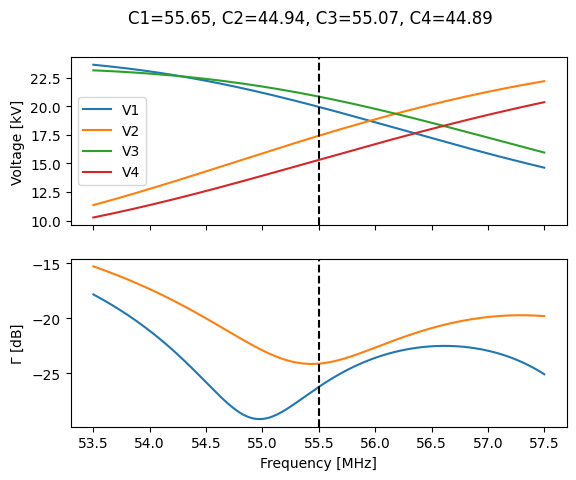

In [103]:
Cs = C_match_org
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(freqs.f_scaled, np.abs(ant2.voltages(power=[1,1], phase=[0,np.pi], Cs=Cs)))
axes[1].plot(freqs.f_scaled, ant2.s_act_db(power=[1,1], phase=[0,np.pi], Cs=Cs))
axes[0].legend(['V1','V2','V3','V4'])
axes[1].set_ylabel('$\Gamma$ [dB]')
axes[0].set_ylabel('Voltage [kV]')
axes[1].set_xlabel('Frequency [MHz]')
[ax.axvline(frec, ls='--', c='k') for ax in axes]
fig.suptitle(f'C1={C_match_org[0]}, C2={C_match_org[1]}, C3={C_match_org[2]}, C4={C_match_org[3]}')
plt.savefig(f'fig_balance/before_{name}.png', dpi=300, bbox_inches='tight')

In [104]:
def capacitor_function(Cs, RangeS=-20, power=[1,1], phase=[0,np.pi]):
    # WARNING: assume single frequency
    V1, V2, V3, V4 = ant.voltages(power=power, phase=phase, Cs=list(Cs))[0]
    Sact_left, Sact_right = ant.s_act_db(power=power, phase=phase, Cs=list(Cs))[0]

    # limit of reflection
    penalty = 0
    if Sact_left > RangeS:
        penalty += 1000 * (Sact_left - RangeS)
    if Sact_right > RangeS:
        penalty += 1000 * (Sact_right - RangeS)

    V12 = np.abs(np.abs(V1) - np.abs(V2))
    V13 = np.abs(np.abs(V1) - np.abs(V3))
    V14 = np.abs(np.abs(V1) - np.abs(V4))
    V23 = np.abs(np.abs(V2) - np.abs(V3))
    V24 = np.abs(np.abs(V2) - np.abs(V4))
    V34 = np.abs(np.abs(V3) - np.abs(V4))

    diffs = [V12,V13,V14,V23,V24,V34]
    value = np.maximum.reduce(diffs)+penalty

    
    return value.item()    

In [105]:
def callback_func(xk):
    history_x.append(np.copy(xk))


    fval = capacitor_function(xk, RangeS, power, phase)
    history_f.append(fval)

In [106]:
history_x = []
history_f = []


Cs = C_match_org
bounds = [(30,120),(30,120),(30,120),(30,120)]
RangeS = -20
power = [1,1]
phase = [0,np.pi]

res = minimize(
    capacitor_function, 
    x0=Cs,
    args=(RangeS,power,phase),
    bounds=bounds,
    method="SLSQP",
    callback=callback_func,
    options={'maxiter':1000}
)


# Results

In [107]:
print(f'voltage difference:{res.fun:.2f} kV')
print(f'reflection coefficient: {RangeS} dB')
print(f'capacitors value (initial):{np.array(C_match_org)} pF')
print(f'capacitors value (optimized):{np.round(res.x,2)} pF')
print(f'capacitors changes:{np.round(C_match_org-res.x,2)} pF')

voltage difference:0.26 kV
reflection coefficient: -20 dB
capacitors value (initial):[55.65 44.94 55.07 44.89] pF
capacitors value (optimized):[56.86 45.52 55.95 46.55] pF
capacitors changes:[-1.21 -0.58 -0.88 -1.66] pF


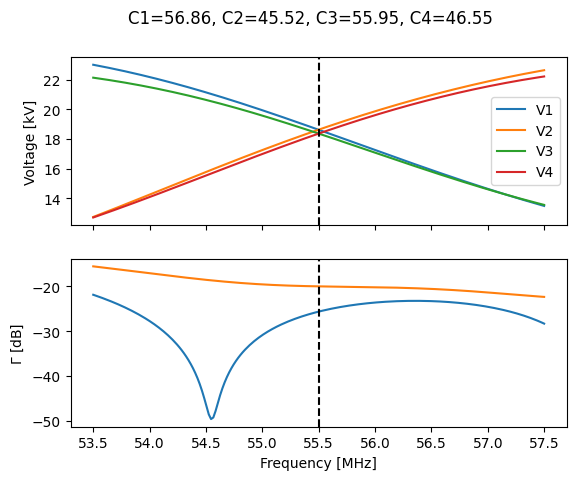

In [108]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(freqs.f_scaled, np.abs(ant2.voltages(power=[1,1], phase=[0,np.pi], Cs=list(res.x))))
axes[1].plot(freqs.f_scaled, ant2.s_act_db(power=[1,1], phase=[0,np.pi], Cs=list(res.x)))
axes[0].legend(['V1','V2','V3','V4'])
axes[1].set_ylabel('$\Gamma$ [dB]')
axes[0].set_ylabel('Voltage [kV]')
axes[1].set_xlabel('Frequency [MHz]')
[ax.axvline(frec, ls='--', c='k') for ax in axes]
fig.suptitle(f'C1={np.round(res.x,2)[0]}, C2={np.round(res.x,2)[1]}, C3={np.round(res.x,2)[2]}, C4={np.round(res.x,2)[3]}')
plt.savefig(f'fig_balance/after_{name}.png', dpi=300, bbox_inches='tight')

# parameters' scanning

In [10]:
# find the match point for a given frequency and solution
C_match_org = ant.match_both_sides(f_match=frec*1e6, solution_number=1, decimals=2)

Looking for individual solutions separately for 1st guess...
Wrong solution found ! Re-doing...
False solution #1: [150. 150.]
Wrong solution found ! Re-doing...
False solution #1: [150. 150.]
Wrong solution found ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [51.34948564 46.09003106]
Rounded result: [np.float64(51.35), np.float64(46.09), np.float64(150.0), np.float64(150.0)]
Wrong solution found ! Re-doing...
False solution #1: [150. 150.]
Wrong solution found ! Re-doing...
False solution #1: [150. 150.]
Wrong solution found ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [50.99748213 46.25109066]
Rounded result: [np.float64(150.0), np.float64(150.0), np.float64(51.0), np.float64(46.25)]
Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [51.8773321  46.55332875 51.61145609 46.73703868]
Rounded result: [np.float64(51.88), np.float64(46.55), np.float64(51.61), np.float64(46.74)]

In [11]:

C1 = np.arange(40,60,0.5)
C2 = np.arange(40,60,0.5)
C_m = C_match_org


In [12]:
Sr = np.zeros((len(C1), len(C2)), dtype=complex)
Sl = np.zeros((len(C1), len(C2)), dtype=complex)
V10 = np.zeros((len(C1), len(C2)), dtype=complex)
V20 = np.zeros((len(C1), len(C2)), dtype=complex)
V30 = np.zeros((len(C1), len(C2)), dtype=complex)
V40 = np.zeros((len(C1), len(C2)), dtype=complex)
for i in range(len(C1)):
    for j in range(len(C2)):
        C_m[0] = C1[i]
        C_m[1] = C2[j]
        V10[i,j], V20[i,j], V30[i,j], V40[i,j] = ant.voltages(power=[1,1], phase=phase, Cs=list(C_m))[0]
        Sl[i,j], Sr[i,j] = ant.s_act_db(power=[1,1], phase=phase, Cs=list(C_m))[0]

In [13]:
V12 = np.abs(V10)-np.abs(V20)
V13 = np.abs(V10)-np.abs(V30)
V14 = np.abs(V10)-np.abs(V40)
V23 = np.abs(V20)-np.abs(V30)
V24 = np.abs(V20)-np.abs(V40)
V34 = np.abs(V30)-np.abs(V40)
V12_ang = np.angle(V10,deg=True)-np.angle(V20,deg=True)
V12_r = np.real(V10)-np.real(V20)
V12_i = np.imag(V10)-np.imag(V20)

C:\Users\YJ281217\AppData\Local\miniconda3\envs\icrf\Lib\site-packages\matplotlib\contour.py:1364: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
C:\Users\YJ281217\AppData\Local\miniconda3\envs\icrf\Lib\site-packages\matplotlib\contour.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
C:\Users\YJ281217\AppData\Local\miniconda3\envs\icrf\Lib\site-packages\numpy\ma\core.py:2892: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


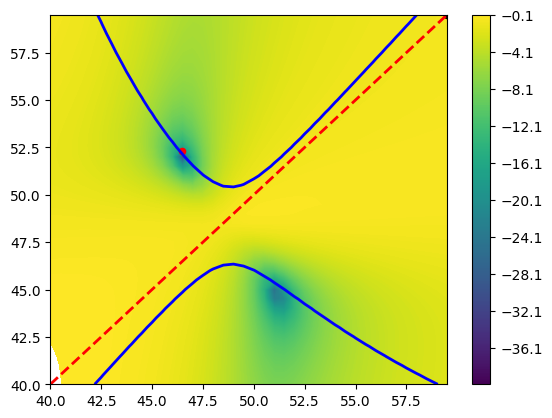

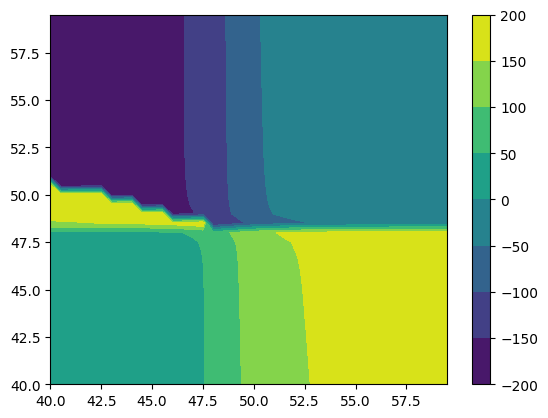

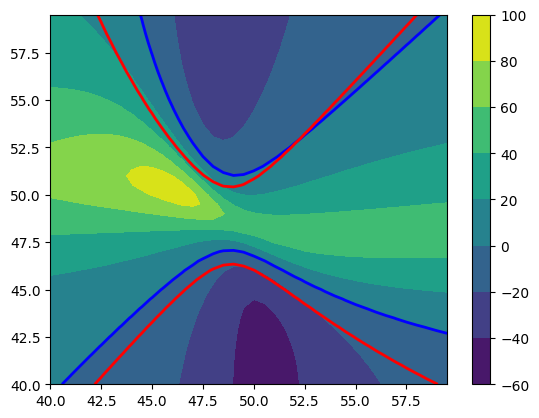

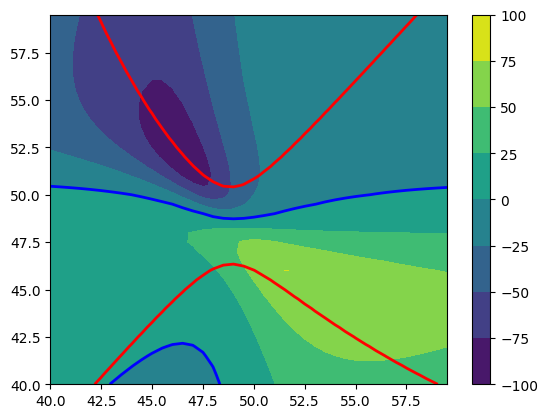

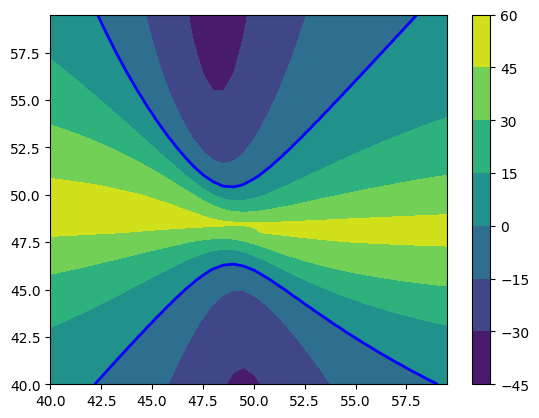

In [14]:
#cp1 = plt.contourf(C1, C2, V13,levels=levels)
levels = np.arange(-40,0,0.1)
plt.figure()
cp1 = plt.contourf(C1, C2, Sl,levels = levels)
cp2 = plt.contour(C1, C2, V12, levels=[0], colors='blue', linewidths=2)
#cp3 = plt.contour(C1, C2, V13, levels=[0], colors='red', linewidths=2)
#cp4 = plt.contour(C1, C2, V14, levels=[0], colors='blue', linewidths=2)
#cp5 = plt.contour(C1, C2, V23, levels=[0], colors='blue', linewidths=2)
#cp6 = plt.contour(C1, C2, V24, levels=[0], colors='blue', linewidths=2)
#cp6 = plt.contour(C1, C2, V34, levels=[0], colors='blue', linewidths=2)
plt.colorbar(cp1)

plt.scatter(res.x[1],res.x[0],s=20,c='red')
plt.scatter(C_match_org[1],C_match_org[0],s=20,c='black')
plt.plot([min(C1),max(C1)],[min(C2),max(C2)], color='red', linewidth=2, linestyle='--')

plt.figure()
cp1 = plt.contourf(C1, C2, V12_ang)
plt.colorbar(cp1)

plt.figure()
cp1 = plt.contourf(C1, C2, V12_r)
cp2 = plt.contour(C1, C2, V12_r, levels=[0], colors='blue', linewidths=2)
cp3 = plt.contour(C1, C2, V12, levels=[0], colors='red', linewidths=2)
plt.colorbar(cp1)
plt.figure()
cp1 = plt.contourf(C1, C2, V12_i)
cp2 = plt.contour(C1, C2, V12_i, levels=[0], colors='blue', linewidths=2)
cp3 = plt.contour(C1, C2, V12, levels=[0], colors='red', linewidths=2)
plt.colorbar(cp1)
plt.figure()
cp1 = plt.contourf(C1, C2, V12)
cp2 = plt.contour(C1, C2, V12, levels=[0], colors='blue', linewidths=2)
plt.colorbar(cp1)

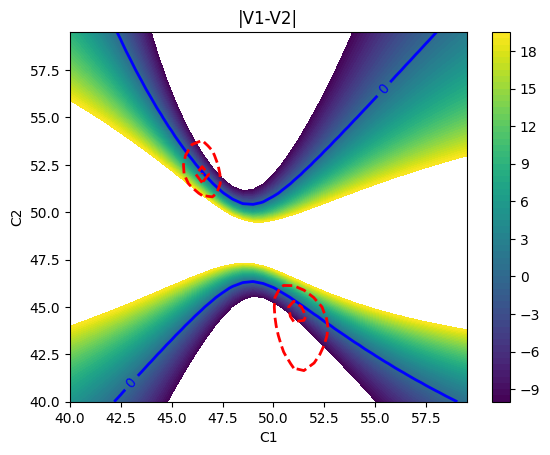

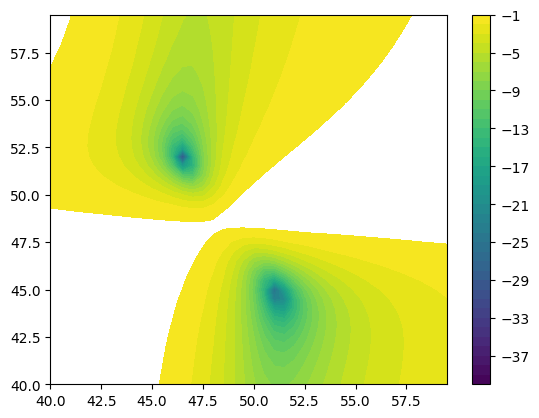

In [15]:
levels = np.arange(-10,20,0.5)
cp1 = plt.contourf(C1, C2, V12,levels=levels)
plt.colorbar(cp1)
cp2 = plt.contour(C1, C2, V12, levels=[0], colors='blue', linewidths=2)
plt.clabel(cp2, inline=True, fontsize=10)
plt.title('|V1-V2|')
plt.xlabel('C1')
plt.ylabel('C2')

#levels = np.arange(-40,0,1)
#cp3 = plt.contourf(C1, C2, Sl,levels=levels)
cp3 = plt.contour(C1, C2, Sl, levels=[-30,-20,-10], colors='red', linewidths=2)

plt.figure()
levels = np.arange(-40,0,1)
cp4 = plt.contourf(C1, C2, Sl,levels=levels)
plt.colorbar(cp4)

NameError: name 'min_pos' is not defined

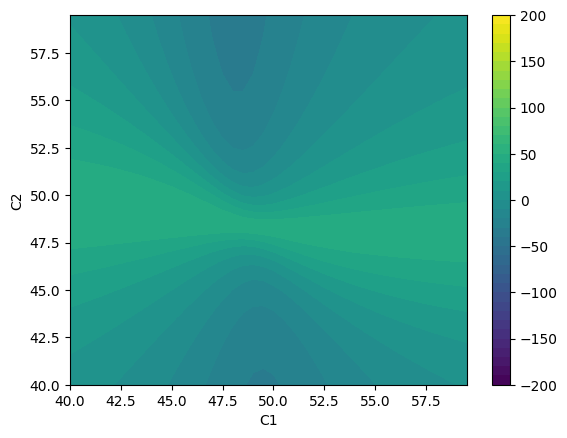

In [16]:
levels = np.arange(-200,210,10)
#plt.figure(figsize=(8,6))
#cp1 = plt.contourf(C1, C2, s_result,levels=levels)
#plt.colorbar(cp1)
#plt.xlabel('C1')
#plt.ylabel('C2')
#plt.title('Re')
#plt.figure(figsize=(8,6))
#levels = np.arange(-5,5,0.01)
cp1 = plt.contourf(C1, C2, V12,levels=levels)
#cp1 = plt.contourf(C1, C2, V1a-V2a)
plt.colorbar(cp1)
plt.xlabel('C1')
plt.ylabel('C2')
#plt.title('|V1-V2|')
plt.scatter(C1[min_pos[1]],C2[min_pos[0]],s=80,c='red')
plt.scatter(C1[min_pos[0]],C2[min_pos[1]],s=80,c='red',label=f'Min $\Gamma$')
#plt.title('|V1|-|V2|--detail--solution1')
plt.title('phasing(V1)-phasing(V2)')
#plt.ylim([52.4,54])
#plt.xlim([45.2,45.8])
cp2 = plt.contour(C1, C2, V1a-V2a, levels=[-130,-120,120,130], colors='blue', linewidths=2)
plt.clabel(cp2, inline=True, fontsize=10)
plt.legend()